# Analyzes data from the static and swing text files, fits them to nonlinear equations, and computes error. 

In [131]:
# all global variables that you'd want to change are in the cell
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

names = 'count, timestamp, temp,  x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro'
path_swing= r"C:\Users\mhanr\Desktop\NIST\Data\7-15\W3.txt"
path_stat = r"C:\Users\mhanr\Desktop\NIST\Data\7-15\T3.txt"

swing_data = np.genfromtxt(path_swing, names = names, skip_footer = 1)
stat_data = np.genfromtxt(path_stat, names = names, skip_footer = 1)

AX_OFFSET = 252.42 # comes from cube calibration
GLOC = 9.80258 # local acceleration of gravity from https://www.ngs.noaa.gov/cgi-bin/grav_pdx.prl
dGloc = 0.00002 # if I ever need it

In [132]:
stat_time = stat_data['timestamp']
stat_time -= stat_time[0] # makes the first entry zero, should help with the fit
stat_count = stat_data['count']
stat_ax_o = stat_data['x_accel'] - AX_OFFSET
stat_gz = stat_data['z_gyro']

stat_ax_resids = stat_ax_o - np.average(stat_ax_o)
stat_gz_resids = stat_gz - np.average(stat_gz)

In [133]:
gz_offset = np.average(stat_gz)

swing_time = swing_data['timestamp']
swing_time -= swing_time[0]
swing_count = swing_data['count']
swing_ax_o = swing_data['x_accel'] - AX_OFFSET
swing_gz_o = swing_data['z_gyro'] - gz_offset

swing_ax_resids = swing_ax_o - np.average(swing_ax_o)
swing_gz_resids = swing_gz_o - np.average(swing_gz_o)

In [134]:
# this is where the fun begins
def accel(x, g, k, d, e, f):
    return g * np.exp(-k*x) * np.cos( (d*np.cos(w*x)+e*np.sin(w*x))) + f
def gyro(t, k, w, a, b, c):
    return np.exp(-k*t) * ( w * ( a * np.cos(w*t) + b * np.sin(w*t) ) ) + c

In [151]:
from scipy.optimize import curve_fit
# this is where the actual fitting begins
accel_guesses =  [9213.75,  0.00181236, -0.0498, -1.0013, 9876.6] # you will likely need to change this!
gyro_guesses = [0.007126082, 5.148, 5753.85, -271.69, 16.24] # and this!

popt1, pcov1 = curve_fit(gyro, swing_time, swing_gz_o)
w = popt1[1] # needed for the next fit!
popt0, pcov0 = curve_fit(accel, swing_time, swing_ax_o)

g, k, d, e, f = popt0
ka, w, a, b, c = popt1

accel_uncerts = dg, dk, dd, de, df = np.sqrt(np.diag(pcov0))
gyro_uncerts = dka, dw, da, db, dc = np.sqrt(np.diag(pcov1))

A = np.average(stat_ax_o)
dA = np.std(stat_ax_o)

params = [a,b,d,e,f,g,A,w]
uncerts = [da, db, dd, de, df, dg, dA, dw]

<ipython-input-134-2c138b2173ee>:3: RuntimeWarning: overflow encountered in exp
  return g * np.exp(-k*x) * np.cos( (d*np.cos(w*x)+e*np.sin(w*x))) + f
<ipython-input-134-2c138b2173ee>:3: RuntimeWarning: overflow encountered in multiply
  return g * np.exp(-k*x) * np.cos( (d*np.cos(w*x)+e*np.sin(w*x))) + f


In [152]:
import sympy as sp # a python-based symbolic manipulator
# a list of symbols to represent the independent variables
gs,ks,ds,es,fs,kas,ws,a_s,bs,cs = sp.symbols('g k d e f ka w a b c')
xs, ts = sp.symbols('x t')
# equation for accel that uses these independent variables 
accel_sym = gs * sp.E**(-ks*xs) * sp.cos( (ds*sp.cos(ws*xs)+es*sp.sin(ws*xs))) + fs
gyro_sym = sp.E**(-kas*ts) * ( ws * ( a_s * sp.cos(ws*ts) + bs * sp.sin(ws*ts) ) ) + cs

In [153]:
'''
try as I might, I could not get these to work. Lambdify just won't work today for some reason.
What I did instead was print its outputs and put it in the cell below this one with the 
proper numpy syntax. 
'''
# def grad_func(eq):
#     # these conditionals are a dumb workaround but should work
#     if eq == accel_sym:
#         symbols = gs,ks,ds,es,fs
#         sym_list = g,k,d,e,f
#     elif eq == gyro_sym:
#         symbols = kas,ws,a_s,bs,cs
#         sym_list = ka,w,a,b,c
#     # returns the matrix of numerical partial deriviatves (i.e., the gradient)
#     sym_partial_derivs = [sp.diff(eq, var) for var in symbols]
#     print(sym_partial_derivs)
#     grad = []
#     for func in sym_partial_derivs:
#         func = sp.lambdify(symbols, func, 'numpy')
#         grad.append(func)
#     return grad

# accel_grad = grad_func(accel_sym)

"\ntry as I might, I could not get these to work. Lambdify just won't work today for some reason.\n"

In [154]:
def gyro_grad(t, w, a, b, c, ka):
    # this list of partials comes from 
    return np.array([-t*w*(a*np.cos(t*w) + b*np.sin(t*w))*np.exp(-ka*t),
             w*(-a*t*np.sin(t*w) + b*t*np.cos(t*w))*np.exp(-ka*t) + (a*np.cos(t*w) + b*np.sin(t*w))*np.exp(-ka*t), 
             w*np.exp(-ka*t)*np.cos(t*w),
             w*np.exp(-ka*t)*np.sin(t*w), 
             1])

In [155]:
def accel_grad(x,k,d,e,f,g):
    return np.array([np.exp(-k*x)*np.cos(d*np.cos(w*x) + e*np.sin(w*x)),
 -g*x*np.exp(-k*x)*np.cos(d*np.cos(w*x) + e*np.sin(w*x)), 
 -g*np.exp(-k*x)*np.sin(d*np.cos(w*x) + e*np.sin(w*x))*np.cos(w*x),
 -g*np.exp(-k*x)*np.sin(w*x)*np.sin(d*np.cos(w*x) + e*np.sin(w*x)), 
 1])

In [161]:
# okay, time to make an error bar
gg = gyro_grad(swing_time, *popt1)
ag = accel_grad(swing_time, *popt0)

gyro_var = 0
accel_var = 0
for i in range(len(gg)):
    gyro_var += (gg[i] * gyro_uncerts[i])**2
    accel_var +=(ag[i] * accel_uncerts[i])**2

<ipython-input-154-ea547b00cf5c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([-t*w*(a*np.cos(t*w) + b*np.sin(t*w))*np.exp(-ka*t),


In [162]:
accel_fit = accel(swing_time, *popt0)
gyro_fit = gyro(swing_time, *popt1)

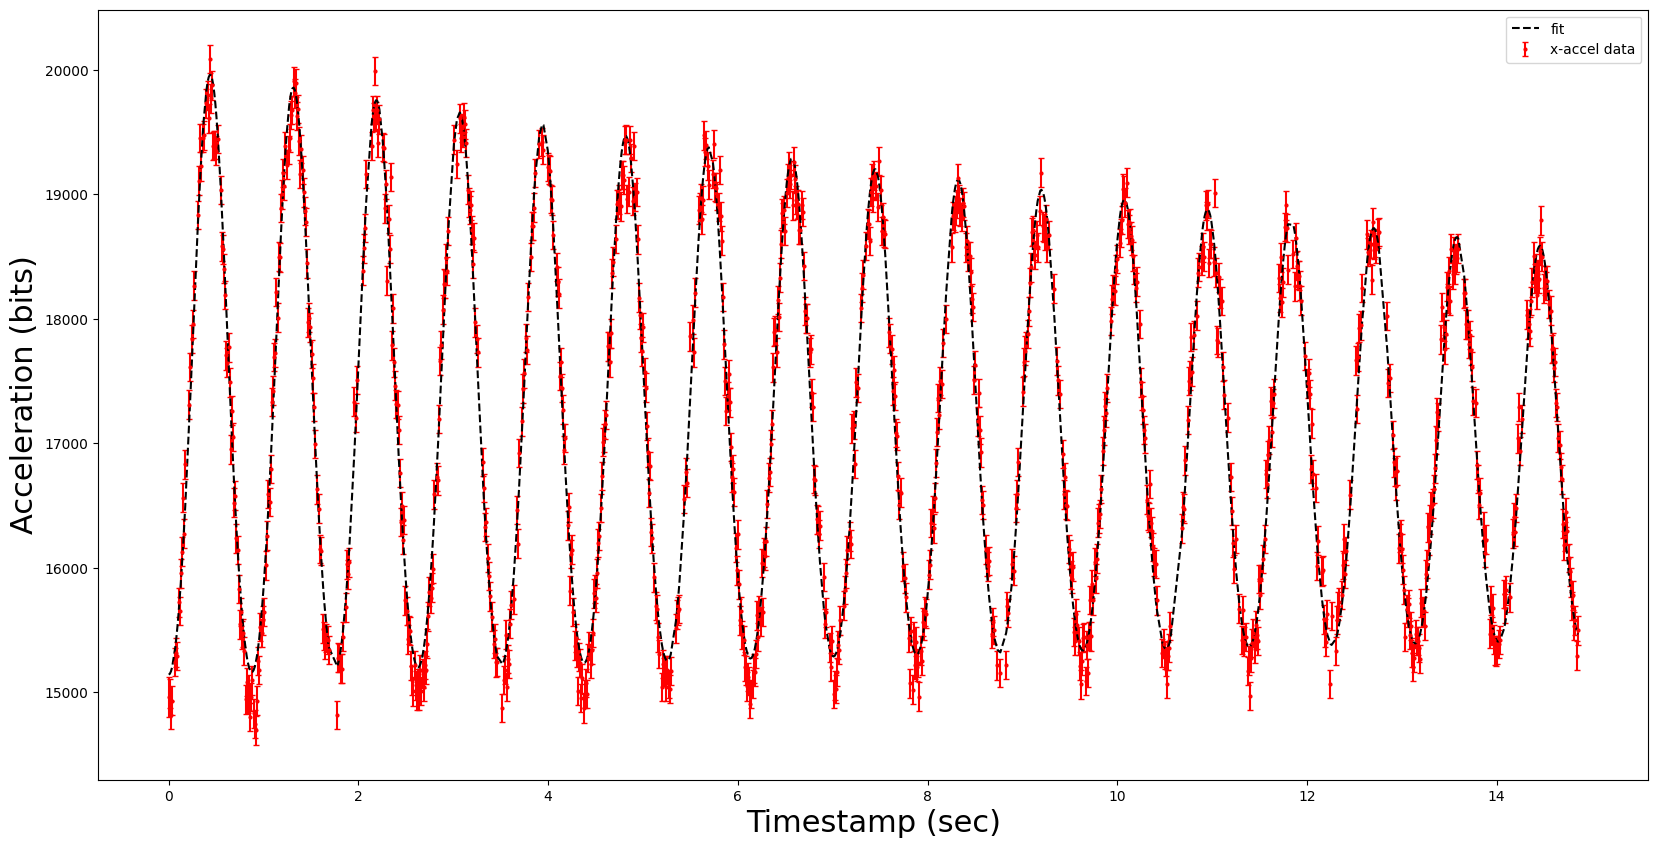

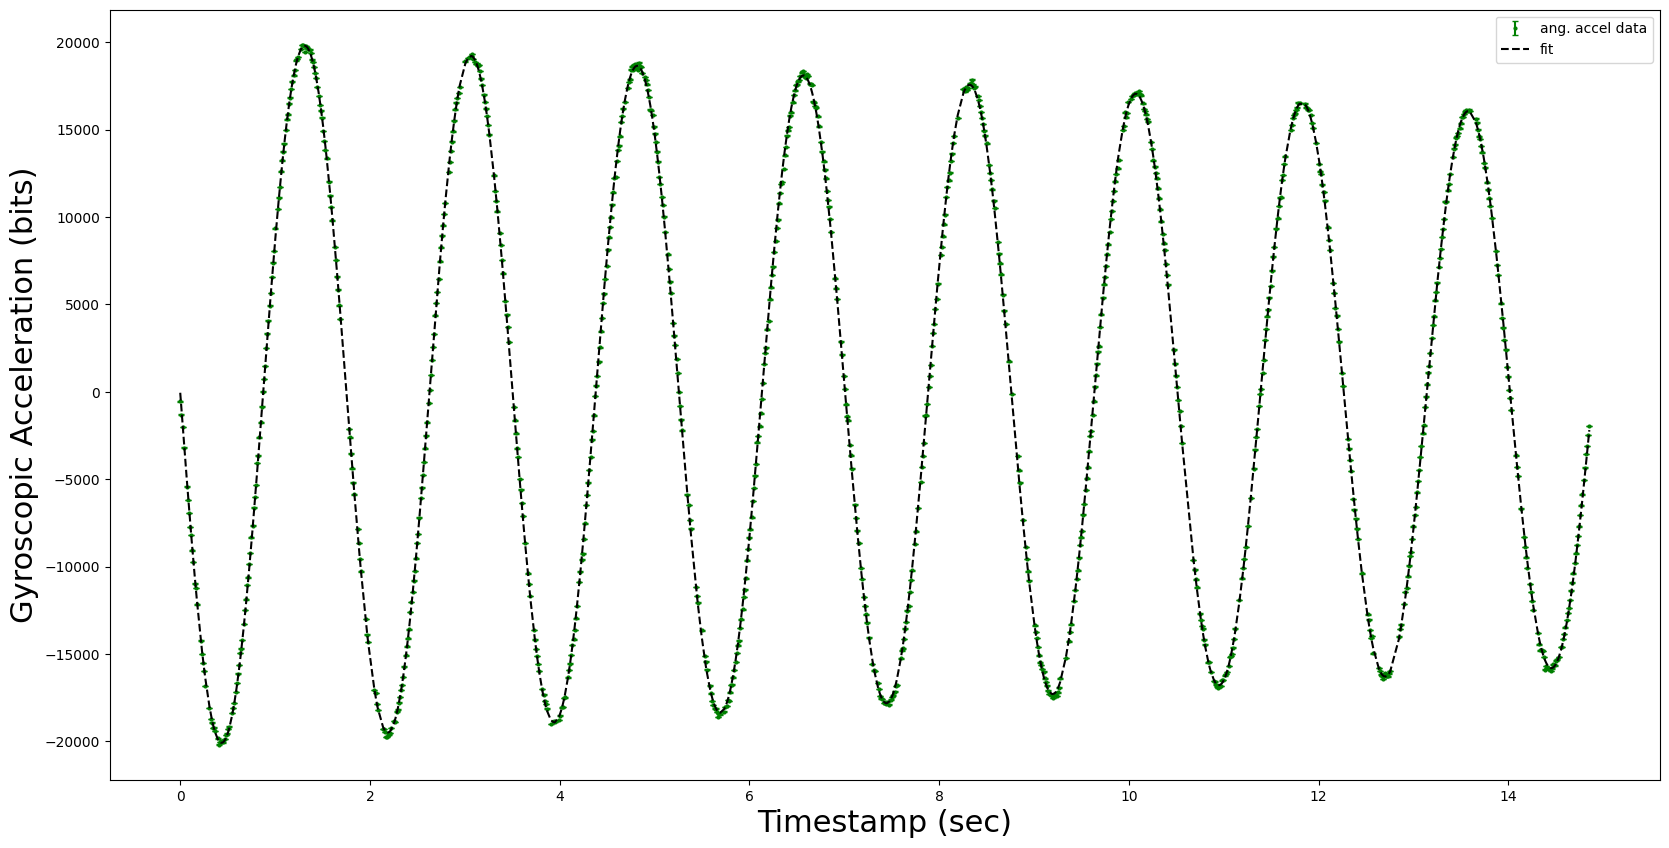

In [172]:
plt.figure(figsize = (20, 10))
plt.errorbar(swing_time, swing_ax_o, yerr = 2*np.sqrt(accel_var), fmt = 'ro', 
             label = 'x-accel data', markersize = 2, capsize = 2)
plt.plot(swing_time, accel_fit, 'k--', label = 'fit')
plt.legend()
plt.xlabel('Timestamp (sec)', size = 22)
plt.ylabel("Acceleration (bits)", size = 22)
plt.show()
plt.figure(figsize = (20, 10))
plt.errorbar(swing_time, swing_gz_o, yerr = 2*np.sqrt(gyro_var), fmt = 'go', 
             label = 'ang. accel data', markersize = 2, capsize = 2)
plt.errorbar(swing_time, gyro_fit, fmt = 'k--', label = 'fit')
plt.legend()
plt.xlabel('Timestamp (sec)', size = 22)
plt.ylabel('Gyroscopic Acceleration (bits)', size = 22)
plt.show()